## Analyze KNN Results COPY

In [1]:
# General imports
import torch
import numpy as np
import os, sys
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.neighbors import KNeighborsClassifier
# from PIL import Image

In [2]:
# Local imports
sys.path.insert(0, 'src')
from test import predict
from utils import read_json, load_image, read_lists, prepare_device
from utils.analysis import knn, display_nearest_neighbors
import utils.visualizations as visualizations
import model.model as module_arch
from parse_config import ConfigParser



In [3]:
# Define visualization function

def show_results(results, class_list, idx, title, n_show=10):
    # pre_edit_resuilts = pre_edit_knn[data_type]
    # Keys: 'indices', 'distances', 'image_paths', 'labels'
    anchor_indices = results['indices'][idx][:n_show]
    anchor_distances = results['distances'][idx][:n_show]
    anchor_image_paths = results['image_paths'][idx][:n_show]
    anchor_labels = results['labels'][idx][:n_show]
    # anchor_labels = [class_list[label] for label in anchor1_labels]
    anchor_titles = []
    for label, distance in zip(anchor_labels, anchor_distances):
        anchor_titles.append("{} ({:.3f})".format(class_list[label], distance))

    display_nearest_neighbors(
        image_paths=anchor_image_paths,
        labels=anchor_titles,
        figure_title=title)

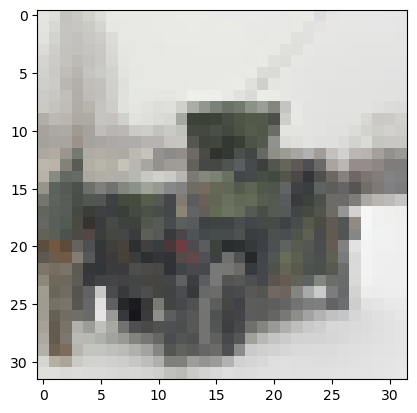

Key image


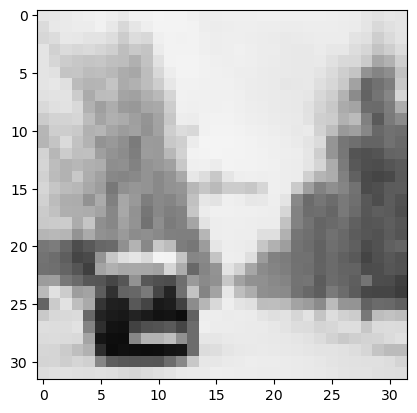

Value image


In [47]:
# Define constants, paths
key_image_path = 'data/editing/dummy/tank2.jpg'
value_image_path = 'data/editing/dummy/tank1.jpg'

# Real with K = 100
# restore_dir = 'saved/edit/knn/CINIC10_ImageNet-VGG_16/1213_132801/models'
# Real with K = 10
# restore_dir = 'saved/edit/knn/CINIC10_ImageNet-VGG_16/1212_175720/models'
# Dummy with K = 10
restore_dir = 'saved/edit/debug/CINIC10_ImageNet-VGG_16/1214_091214/models'

pre_edit_knn_path = os.path.join(restore_dir, 'pre_edit_10-nn.pth')
post_edit_knn_path = os.path.join(restore_dir, 'post_edit_10-nn.pth')

# original_model_path = "external_code/PyTorch_CIFAR10/cifar10_models/state_dicts/vgg16_bn.pt"
edited_model_path = os.path.join(restore_dir, "edited_model.pth")

config_path = os.path.join(restore_dir, "config.json")

# Class list dictionary
class_list_path = "metadata/cinic-10/class_names.txt"
class_list = read_lists(class_list_path)
IMAGE_SIZE = (32, 32)

# Load config file

config_json = read_json(config_path)
config = ConfigParser(config_json)
layernum = config.config['layernum']
device, device_ids = prepare_device(config['n_gpu'])

# Load original and edited model
# original_model = config.init_obj('arch', module_arch, layernum=layernum)
# original_context_model = original_model.context_model
# original_model = original_model.restore_model(original_model_path)
edited_model = config.init_obj('arch', module_arch, layernum=layernum)
edited_model.restore_model(edited_model_path)
edited_context_model = edited_model.context_model

original_model.eval()
edited_model.eval()

# KNN values
knn_data_types = ['images', 'features', 'logits']
K = 10

key_image = load_image(key_image_path, resize=IMAGE_SIZE)
value_image = load_image(value_image_path, resize=IMAGE_SIZE)
visualizations.show_image(key_image)
print("Key image")
visualizations.show_image(value_image)
print("Value image")

### Load KNN Results Before and After Edit

In [48]:
pre_edit_knn = torch.load(pre_edit_knn_path)
post_edit_knn = torch.load(post_edit_knn_path)

### Features Visualizations

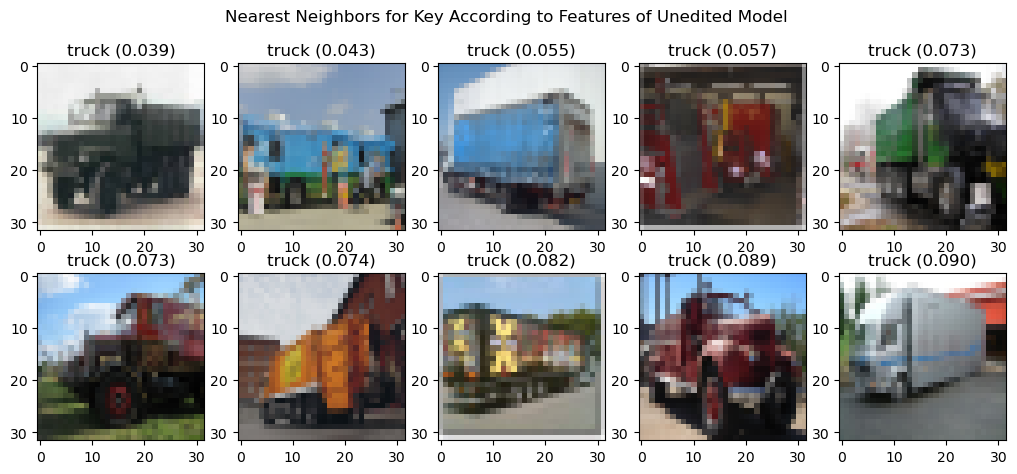

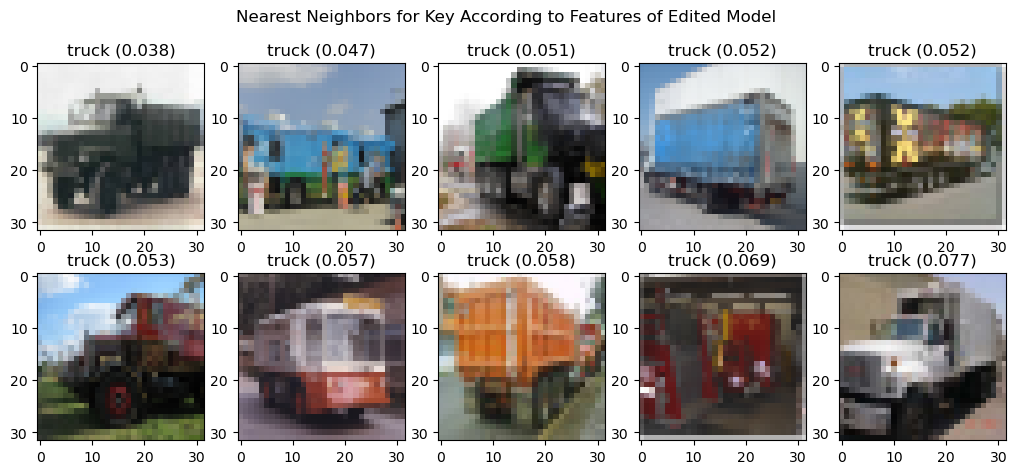

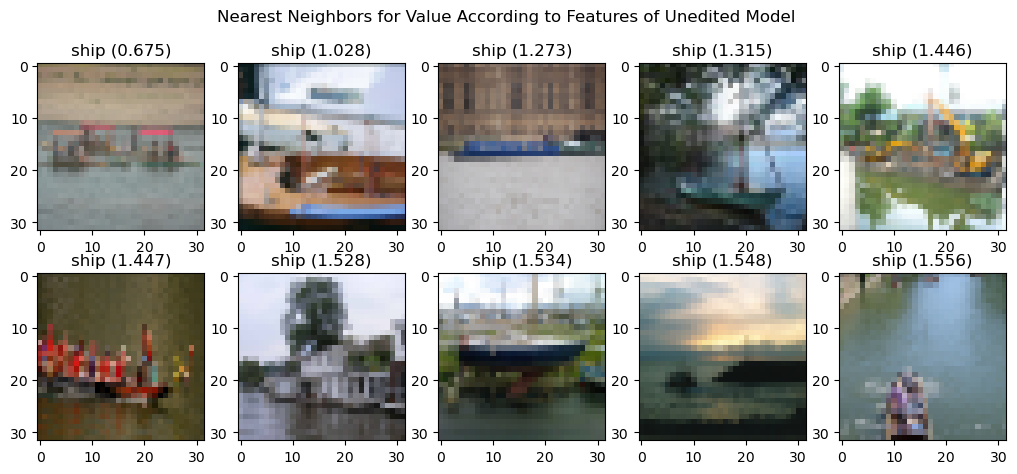

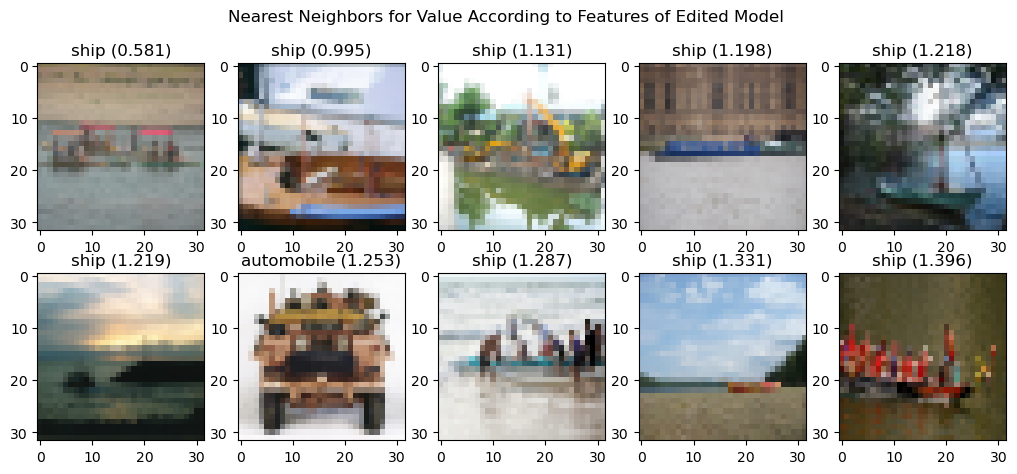

In [49]:
# Show visualizations for KNN for original and modified images according to unedited model

# Based on features first
# data_type = 'features'
pre_edit_feature_knn = pre_edit_knn['features']
post_edit_feature_knn = post_edit_knn['features']

# Pre edit features for key (tank2)
show_results(
    results=pre_edit_feature_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Unedited Model')

# Post edit features for key (tank2)
show_results(
    results=post_edit_feature_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Features of Edited Model')

# Features for value (tank1)
show_results(
    results=pre_edit_feature_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Unedited Model')

show_results(
    results=post_edit_feature_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Features of Edited Model')


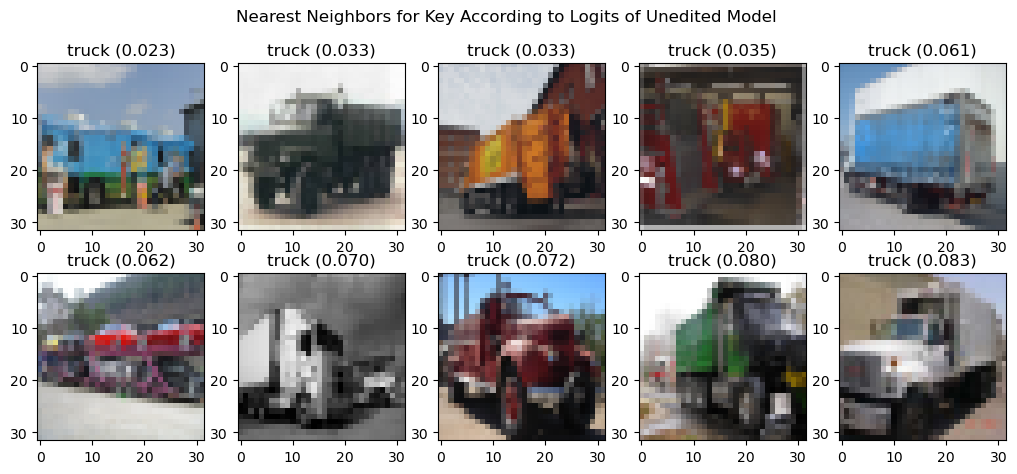

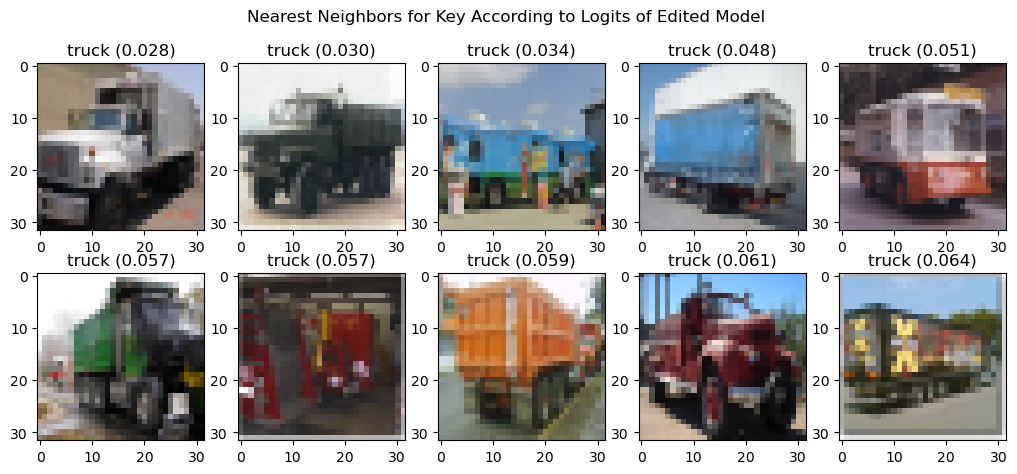

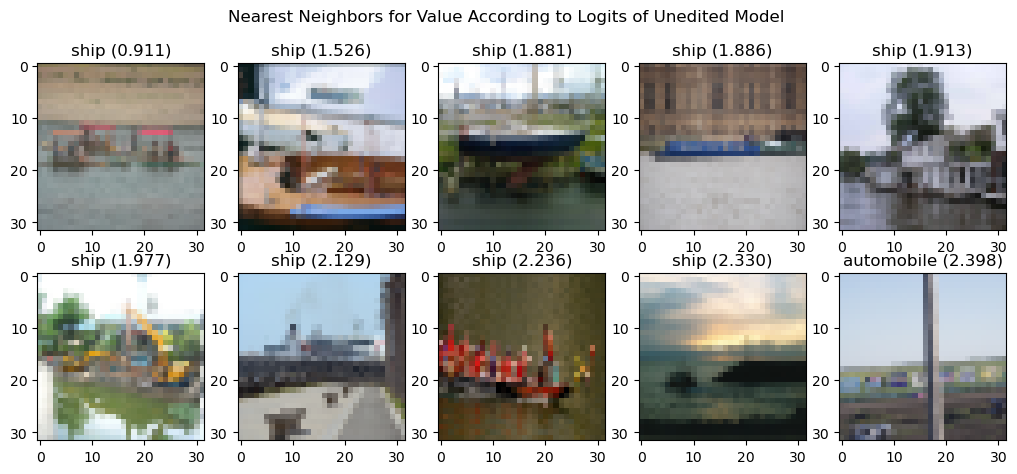

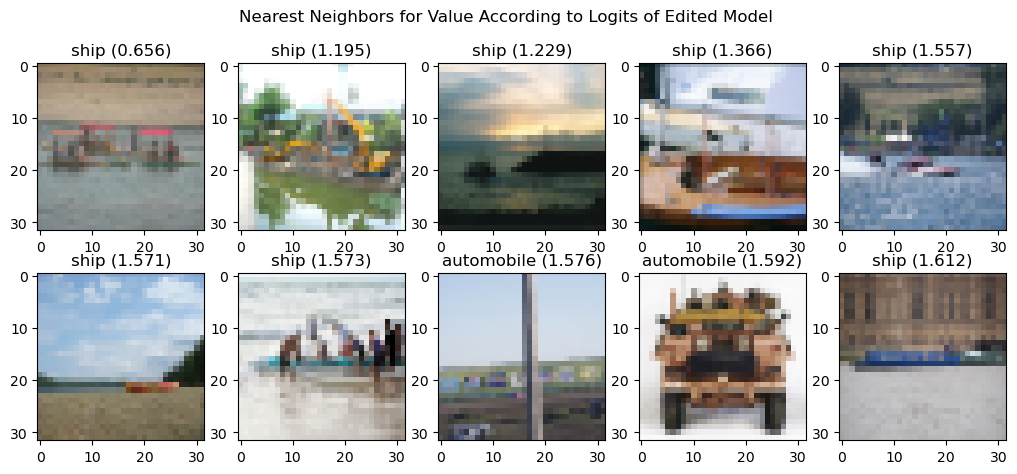

In [37]:
# LOGITS
pre_edit_logits_knn = pre_edit_knn['logits']
post_edit_logits_knn = post_edit_knn['logits']

# Logits for key (tank2)
show_results(
    results=pre_edit_logits_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Unedited Model')
show_results(
    results=post_edit_logits_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Logits of Edited Model')

# Logits for value (tank1)
show_results(
    results=pre_edit_logits_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Unedited Model')
show_results(
    results=post_edit_logits_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Logits of Edited Model')

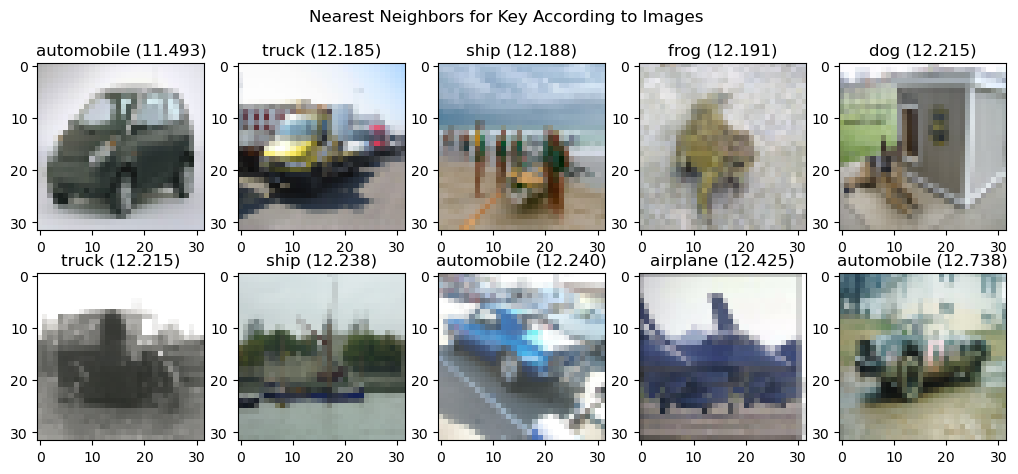

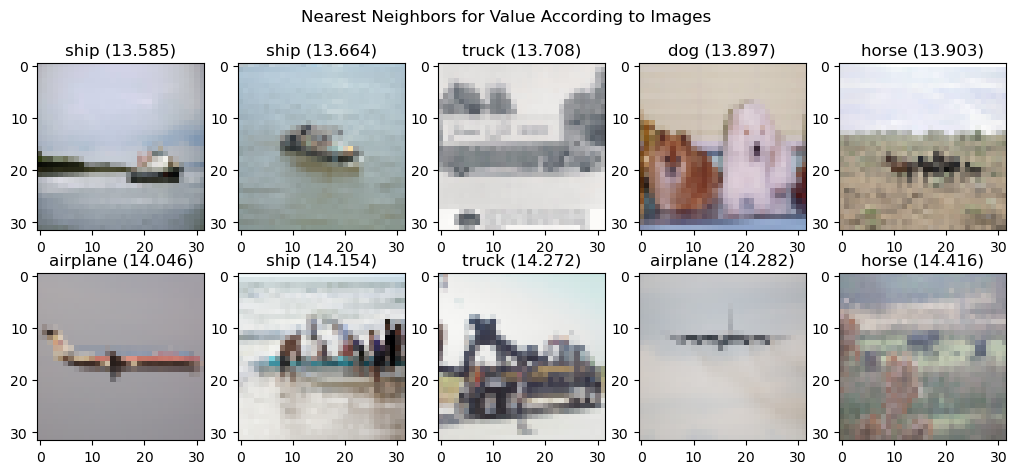

In [38]:
# IMAGES
pre_edit_images_knn = pre_edit_knn['images']
post_edit_images_knn = post_edit_knn['images']
# Features for key (tank2)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=0, 
    title='Nearest Neighbors for Key According to Images')

# Features for value (tank1)
show_results(
    results=pre_edit_images_knn, 
    class_list=class_list, 
    idx=1, 
    title='Nearest Neighbors for Value According to Images')

### Given neighbors of the value image, find distances from key

In [39]:
from scipy.spatial import distance
def calculate_distance(u, v, metric='minkowski'):
    if metric == 'minkowski':
        return distance.minkowski(u, v)
    else:
        raise ValueError("Distance metric {} not supported.".format(metric))

In [40]:
def calculate_distances(
    vectors, 
    anchor, 
    metric='minkowski'):
    '''
    Given a list of vectors, calculate the distances from anchor using metric provided

    Arg(s):
        vectors : N x D np.array or list[np.array]
            N vectors of same shape of anchor
        anchor : D-dim np.vector
            Point to calculate distance from
        metric : str
            type of distance metric to use

    Returns:
        N-dim np.array : list of distances from anchor point
    '''
    distances = []
    for vector in vectors:
        distance = calculate_distance(vector, anchor, metric=metric)
        distances.append(distance)
    
    distances = np.stack(distances, axis=0)

    return distances

In [41]:
# Sanity check that A's neighbors get the correct distances in feature space

features_results = pre_edit_knn['images']
knn_distances = features_results['distances'][0]
knn_image_paths = features_results['image_paths'][0]
flattened_key_image = np.copy(key_image)
flattened_key_image = flattened_key_image.flatten()

images = []
for path in knn_image_paths:
    
    image = load_image(path, resize=IMAGE_SIZE)
    image = image.flatten()
    images.append(image)

distances = calculate_distances(
    vectors=images,
    anchor=flattened_key_image
)
for knn_dist, minkowski_dist in zip(knn_distances, distances):
    assert np.abs(knn_dist - minkowski_dist) < 1e-5

### Key Image Neighbor Analysis

Find the top neighbors of the key image before the edit
Calculate the distances in the feature and logit space to the value image before and after the edit and see how they differ.

How to take into account the changes in the value image's representation in the feature and logit space due to the edit as well?

In [51]:
# Get features and logits of key, value, key neighbors and value neighbors before edit

# features
data_type = 'features'
pre_edit_features = pre_edit_knn[data_type]
pre_edit_key_features = pre_edit_features['anchor_data'][0]
pre_edit_key_neighbor_features = pre_edit_features['neighbor_data'][0]
pre_edit_key_neighbor_features_image_paths = pre_edit_features['image_paths'][0]

pre_edit_value_features = pre_edit_features['anchor_data'][1]
pre_edit_value_neighbor_features = pre_edit_features['neighbor_data'][1]
pre_edit_value_neighbor_features_image_paths = pre_edit_features['image_paths'][1]

# Repeat for after edit
post_edit_features = post_edit_knn[data_type]
post_edit_key_features = post_edit_features['anchor_data'][0]
post_edit_key_neighbor_features = post_edit_features['neighbor_data'][0]
post_edit_key_neighbor_features_image_paths = post_edit_features['image_paths'][0]


post_edit_value_features = post_edit_features['anchor_data'][1]
post_edit_value_neighbor_features = post_edit_features['neighbor_data'][1]
post_edit_value_neighbor_features_image_paths = post_edit_features['image_paths'][1]


# logits
data_type = 'logits'
pre_edit_logits = pre_edit_knn[data_type]
pre_edit_key_logits = pre_edit_logits['anchor_data'][0]
pre_edit_key_neighbor_logits = pre_edit_logits['neighbor_data'][0]
pre_edit_key_neighbor_logits_image_paths = pre_edit_logits['image_paths'][0]

pre_edit_value_logits = pre_edit_logits['anchor_data'][1]
pre_edit_value_neighbor_logits = pre_edit_logits['neighbor_data'][1]
pre_edit_value_neighbor_logits_image_paths = pre_edit_logits['image_paths'][1]


# Repeat for after edit
post_edit_logits = post_edit_knn[data_type]
post_edit_key_logits = post_edit_logits['anchor_data'][0]
post_edit_key_neighbor_logits = post_edit_logits['neighbor_data'][0]
post_edit_key_neighbor_logits_image_paths = post_edit_logits['image_paths'][0]


post_edit_value_logits = post_edit_logits['anchor_data'][1]
post_edit_value_neighbor_logits = post_edit_logits['neighbor_data'][1]
post_edit_value_neighbor_logits_image_paths = post_edit_logits['image_paths'][1]



### Comparing Value Image with Key Neighbors

In [52]:
# # Get images that are neighbors of key (idx=0)
# # pre_edit_key_neighbor_images
# feature_neighbor_image_paths = pre_edit_knn['features']['image_paths'][0]
# feature_neighbor_images = []
# for path in feature_neighbor_image_paths:
#     feature_neighbor_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))

# feature_neighbor_images = torch.stack(feature_neighbor_images, dim=0)
# print(feature_neighbor_images.shape)
# # Feed through original and edited model to get features/logits
# with torch.no_grad():
#     feature_neighbor_images = feature_neighbor_images.to(device)
#     original_logits = original_context_model(feature_neighbor_images)
#     original_features = original_model.get_feature_values()['post']
#     original_features = original_features.reshape([original_features.shape[0], -1])

#     print(original_features.shape)

#     edited_logits = edited_context_model(feature_neighbor_images)
#     edited_features = edited_model.get_feature_values()['post']
#     edited_features = edited_features.reshape([edited_features.shape[0], -1])

#     # get features for value image
#     val_image = torch.tensor(value_image).type(torch.float32).to(device)
#     val_image = torch.unsqueeze(val_image, dim=0)
#     original_val_logits = original_context_model(val_image)
#     original_val_features = original_model.get_feature_values()['post']
#     original_val_features = original_val_features.reshape([original_val_features.shape[0], -1])

#     edited_val_logits = edited_context_model(val_image)
#     edited_val_features = edited_model.get_feature_values()['post']
#     edited_val_features = edited_val_features.reshape([edited_val_features.shape[0], -1])


# # Convert all back to cpu and numpy
# original_features = original_features.cpu().numpy()
# original_logits = original_logits.cpu().numpy()
# edited_features = edited_features.cpu().numpy()
# edited_logits = edited_logits.cpu().numpy()

# original_val_features = original_val_features.cpu().numpy()
# original_val_logits = original_val_logits.cpu().numpy()
# edited_val_features = edited_val_features.cpu().numpy()
# edited_val_logits = edited_val_logits.cpu().numpy()

torch.Size([10, 3, 32, 32])
torch.Size([10, 512])


In [53]:
# # compute distances from original and edited model for anchor in feature space
# original_model_feature_distances = calculate_distances(
#     vectors=original_features,
#     anchor=original_val_features)

# edited_model_feature_distances = calculate_distances(
#     vectors=edited_features,
#     anchor=edited_val_features)

# print("For the neighbors of the key image, these are the distances in the feature space to the value image before the edit: {}"
#       .format(original_model_feature_distances))
# print("And distances to the value image representation after the edit: {}".format(edited_model_feature_distances))
# change = (edited_model_feature_distances - original_model_feature_distances) / original_model_feature_distances
# mean_change = np.mean(change)
# print("And the percent change: {} {}".format(mean_change, change))

# value_feature_change = np.nan_to_num((edited_val_features - original_val_features) / original_val_features)
# mean_value_feature_change = np.mean(value_feature_change)
# print("Perhaps there is some influence of change in the features of the value image though: {}"
#      .format(mean_value_feature_change))

For the neighbors of the key image, these are the distances in the feature space to the value image before the edit: [4.98777342 4.98202658 4.96568489 4.98126268 5.03129435 5.03127241
 4.96449423 4.92072248 4.95410919 4.95096445]
And distances to the value image representation after the edit: [3.09433055 3.07897639 3.08899593 3.06814647 3.1026926  3.09973812
 3.0640769  3.07506919 3.07550979 3.09557581]
And the percent change: -0.3802653686953307 [-0.37961686 -0.38198315 -0.37793154 -0.3840625  -0.38332119 -0.38390573
 -0.3828018  -0.3750777  -0.37920024 -0.37475297]
Perhaps there is some influence of change in the features of the value image though: -0.20324479043483734


/tmp/ipykernel_2382780/3324102114.py:17: RuntimeWarning: invalid value encountered in divide
  value_feature_change = np.nan_to_num((edited_val_features - original_val_features) / original_val_features)


In [156]:
# # compute distances in logit space
# original_model_logit_distances = calculate_distances(
#     vectors=original_logits,
#     anchor=original_val_logits)

# edited_model_logit_distances = calculate_distances(
#     vectors=edited_logits,
#     anchor=edited_val_logits)

# # print(original_logits)
# print(original_val_logits)
# # print(edited_logits)
# print(edited_val_logits)
# print("For the neighbors of the key image, these are the distances in the logit space to the value image before the edit: {}"
#       .format(original_model_logit_distances))
# print("And distances to the value image representation after the edit: {}".format(edited_model_logit_distances))
# change = (edited_model_logit_distances - original_model_logit_distances) / original_model_logit_distances
# mean_change = np.mean(change)
# print("And the percent change: {} {}".format(mean_change, change))

# print("original val logits:{}".format(original_val_logits))
# print("edited val logits:{}".format(edited_val_logits))
# # print(np.abs(original_val_logits - edited_val_logits))
# # print(np.mean(np.abs(original_val_logits - edited_val_logits)))
# value_logit_change = np.nan_to_num((edited_val_logits - original_val_logits) / original_val_logits)
# mean_value_logit_change = np.mean(value_logit_change)
# print("Perhaps there is some influence of change in the logits of the value image though: {}"
#      .format(mean_value_logit_change))

[[ 1.1887832  -0.1847669  -0.98308927  0.17026277 -0.26924554 -1.0271344
  -1.3942275  -3.026613    4.1889033   1.3371737 ]]
[[ 1.2579614  -0.1650098  -0.51095563 -0.19014134  0.1705075  -0.47945145
  -1.4941994  -3.475605    4.6654644   0.22146893]]
For the neighbors of the key image, these are the distances in the logit space to the value image before the edit: [8.44179249 8.42616081 8.43860245 8.44065857 8.42479897 8.44758415
 8.40944099 8.42645836 8.42682743 8.41898155 8.40161514 8.43992233
 8.44042492 8.43711758 8.42765236 8.46058464 8.44305897 8.4512558
 8.42214966 8.41431332 8.41196346 8.440938   8.43171883 8.43226624
 8.4028368  8.43001556 8.43187904 8.44037437 8.39793873 8.43518257
 8.44086456 8.42827511 8.43103027 8.43264198 8.45096493 8.40224648
 8.42775249 8.41530323 8.43466663 8.44951534 8.4604435  8.41031551
 8.40712166 8.41433525 8.40088463 8.43279362 8.39891243 8.44752598
 8.42691422 8.42296886 8.40507126 8.40507126 8.40760517 8.44459915
 8.46070385 8.44109058 8.4375200

In [136]:
# original_value_prediction = np.argmax(original_val_logits, axis=1)[0]
# print(original_val_logits.shape, edited_val_logits.shape)
# edited_value_prediction = np.argmax(edited_val_logits, axis=1)[0]

# print(original_value_prediction)
# print(edited_value_prediction)
# # print(original_logits.shape)
# print(original_logits[0])
# print(edited_logits[0])

# original_neighbor_predictions = np.argmax(original_logits, axis=1)
# edited_neighbor_predictions = np.argmax(edited_logits, axis=1)
# print(original_neighbor_predictions)
# print(edited_neighbor_predictions)



(1, 10) (1, 10)
8
8
[ 0.17713006  0.734227   -3.005215    0.67149544 -2.2712648  -3.4122767
 -0.2403324   0.58347607  0.32232085  6.4405046 ]
[ 0.5322636   0.15073746 -1.3281008   0.1431108  -0.63927734 -1.4372005
 -0.675983   -1.3150053   2.154513    2.4149785 ]
[9 9 9 9 9 9 9 9 9 9]
[9 9 9 9 9 9 9 9 9 9]


### Comparing Key Image with Value Neighbors FEATURES
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [55]:
# Load images that are the pre-edit neighbors of value
# Only looking at features
pre_edit_value_neighbor_features_images = []
for path in pre_edit_value_neighbor_features_image_paths:
    pre_edit_value_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_features_images = torch.stack(pre_edit_value_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_features_images = pre_edit_value_neighbor_features_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_features_images)
    pre_edit_value_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.reshape(
        [pre_edit_value_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()
pre_edit_value_neighbors_edited_features = pre_edit_value_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_key_to_pre_value_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_features,
    anchor=pre_edit_key_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_key_to_pre_value_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_features,
    anchor=post_edit_key_features)

print("Features")
print("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model")
print(pre_key_to_pre_value_neighbors_features_distances)
print("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model")
print(post_key_to_pre_value_neighbors_edited_features_distances)


Features
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[4.75551939 4.81841516 5.4559021  5.28566599 6.10862732 4.82579994
 5.30832529 5.12669802 6.11335468 5.71335697]
Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
[3.10040975 3.04068542 3.60269451 3.2790792  3.78846049 3.13000774
 3.72784901 3.61834359 3.79938221 3.5465095 ]


### Comparing Key Image with Value Neighbors LOGITS
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model

and

Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model


In [57]:
# Load images that are the pre-edit neighbors of value
# Only looking at logits
pre_edit_value_neighbor_logits_images = []
for path in pre_edit_value_neighbor_logits_image_paths:
    pre_edit_value_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_value_neighbor_logits_images = torch.stack(pre_edit_value_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_value_neighbor_logits_images = pre_edit_value_neighbor_logits_images.to(device)
    pre_edit_value_neighbors_edited_logits = edited_model(pre_edit_value_neighbor_logits_images)

# Move features and logits to CPU and convert to numpy
pre_edit_value_neighbors_edited_logits = pre_edit_value_neighbors_edited_logits.cpu().numpy()

# Calculate distances between key and neighbors of value before the edit
pre_key_to_pre_value_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbor_logits,
    anchor=pre_edit_key_logits)

pre_key_to_pre_value_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_value_neighbors_edited_logits,
    anchor=post_edit_key_logits)

print("Logits")
print("Anchor: key || pre-edit-model \nVectors: pre-edit-value-neighbors || pre-edit-model")
print(pre_key_to_pre_value_neighbors_logits_distances)
print("Anchor: key || post-edit-model \nVectors: pre-edit-value-neighbors || post-edit-model")
print(pre_key_to_pre_value_neighbors_edited_logits_distances)

Logits
Anchor: key || pre-edit-model 
Vectors: pre-edit-value-neighbors || pre-edit-model
[ 8.07354259  7.61320734  8.8928566   9.52738762  9.20580482  9.93704796
  9.54262447  7.40827608 10.27013111  9.84085464]
Anchor: key || post-edit-model 
Vectors: pre-edit-value-neighbors || post-edit-model
[4.59495211 3.95481992 5.52158642 5.40386152 5.66043806 4.87012577
 4.78704071 3.97603083 4.99469614 4.82863617]


### Comparing Value Image with Key Neighbors FEATURES
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [58]:
# Load images that are the pre-edit neighbors of key
# Only looking at features
pre_edit_key_neighbor_features_images = []
for path in pre_edit_key_neighbor_features_image_paths:
    pre_edit_key_neighbor_features_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_features_images = torch.stack(pre_edit_key_neighbor_features_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_features_images = pre_edit_key_neighbor_features_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_features_images)
    pre_edit_key_neighbors_edited_features = edited_model.get_feature_values()['post']
    pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.reshape(
        [pre_edit_key_neighbors_edited_features.shape[0], -1])

# Move features and logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_features = pre_edit_key_neighbors_edited_features.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_features,
    anchor=pre_edit_value_features)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_features_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_features,
    anchor=post_edit_value_features)

print("Features")
print("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model")
print(pre_value_to_pre_key_neighbors_features_distances)
print("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model")
print(post_value_to_pre_key_neighbors_edited_features_distances)


Features
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[4.98777342 4.9820261  4.96568394 4.98126221 5.03129435 5.03127146
 4.96449375 4.92072153 4.95410919 4.95096397]
Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
[3.09433031 3.07897615 3.0889957  3.06814623 3.10269237 3.09973788
 3.0640769  3.07506895 3.07550979 3.09557557]


### Comparing Value Image with Key Neighbors LOGITS
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model

and

Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model

In [60]:
# Load images that are the pre-edit neighbors of key
# Only looking at logits
pre_edit_key_neighbor_logits_images = []
for path in pre_edit_key_neighbor_logits_image_paths:
    pre_edit_key_neighbor_logits_images.append(load_image(path, as_tensor=True, resize=IMAGE_SIZE))
    
pre_edit_key_neighbor_logits_images = torch.stack(pre_edit_key_neighbor_logits_images, dim=0)
    
# Run these images through the edited model
with torch.no_grad():# get logits for key image
    pre_edit_key_neighbor_logits_images = pre_edit_key_neighbor_logits_images.to(device)
    pre_edit_key_neighbors_edited_logits = edited_context_model(pre_edit_key_neighbor_logits_images)

# Move  logits to CPU and convert to numpy
pre_edit_key_neighbors_edited_logits = pre_edit_key_neighbors_edited_logits.cpu().numpy()

# Calculate feature distances between key and neighbors of value before the edit 
pre_value_to_pre_key_neighbors_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbor_logits,
    anchor=pre_edit_value_logits)

# Calculate feature distances between key post edit and value's original neighbors via post edit model
post_value_to_pre_key_neighbors_edited_logits_distances = calculate_distances(
    vectors=pre_edit_key_neighbors_edited_logits,
    anchor=post_edit_value_logits)

print("logits")
print("Anchor: value || pre-edit-model \nVectors: pre-edit-key-neighbors || pre-edit-model")
print(pre_value_to_pre_key_neighbors_logits_distances)
print("Anchor: value || post-edit-model \nVectors: pre-edit-key-neighbors || post-edit-model")
print(post_value_to_pre_key_neighbors_edited_logits_distances)


logits
Anchor: value || pre-edit-model 
Vectors: pre-edit-key-neighbors || pre-edit-model
[8.43434143 8.43611622 8.41118622 8.44197369 8.39973545 8.43062592
 8.41528606 8.39442158 8.49973679 8.35097408]
Anchor: value || post-edit-model 
Vectors: pre-edit-key-neighbors || post-edit-model
[4.37279177 4.38555765 4.31340981 4.32971287 4.40409803 4.33837032
 4.38589096 4.35385799 4.42939138 4.38404846]


In [199]:
# # Look at how key relates to neighbors of B before and after the edit
# # with torch.no_grad():# get logits for key image
# #     k_image = torch.tensor(key_image).type(torch.float32).to(device)
# #     k_image = torch.unsqueeze(k_image, dim=0)
# #     original_key_logits = original_context_model(k_image).cpu().numpy()
# #     original_key_features = original_model.get_feature_values()['post']
# #     original_key_features = original_key_features.reshape([original_key_features.shape[0], -1]).cpu().numpy()
    
# #     edited_key_logits = edited_context_model(k_image).cpu().numpy()
# #     edited_key_features = edited_model.get_feature_values()['post']
# #     edited_key_features = edited_key_features.reshape([edited_key_features.shape[0], -1]).cpu().numpy()
    
# # Calculate distance from key image -> value neighbors before edit
# # in feature space
# # TODO NEEDS TO BE OLD NEIGHBORS OF B WITH NEW EDITED MODEL
# pre_edit_key_to_val_neighbors_feature_distance = calculate_distances(
#     vectors=pre_edit_value_neighbor_features,
#     anchor=pre_edit_key_features)

# # key image -> value neighbors after edit
# post_edit_key_to_val_neighbors_features_distance = calculate_distances(
#     vectors=post_edit_value_neighbor_features,
#     anchor=post_edit_key_features)

# n_neighbors = pre_edit_key_to_val_neighbors_feature_distance.shape[0]

# step = 10
# for k in range(step, n_neighbors, step):
#     print("For {} nearest neighbors:".format(k))
#     print("Pre edit mean distance: {}".format(np.mean(pre_edit_key_to_val_neighbors_feature_distance[:k])))
#     print("Post edit mean distance: {}".format(np.mean(post_edit_key_to_val_neighbors_features_distance[:k])))


For 10 nearest neighbors:
Pre edit mean distance: 4.9758134365081785
Post edit mean distance: 4.999501276016235
For 20 nearest neighbors:
Pre edit mean distance: 4.975875282287598
Post edit mean distance: 5.042577195167541
For 30 nearest neighbors:
Pre edit mean distance: 5.069450108210246
Post edit mean distance: 5.09300373395284
For 40 nearest neighbors:
Pre edit mean distance: 5.074853539466858
Post edit mean distance: 5.122969877719879
For 50 nearest neighbors:
Pre edit mean distance: 5.107782335281372
Post edit mean distance: 5.172890253067017
For 60 nearest neighbors:
Pre edit mean distance: 5.114935906728109
Post edit mean distance: 5.181579939524332
For 70 nearest neighbors:
Pre edit mean distance: 5.144149187632969
Post edit mean distance: 5.1956549848829
For 80 nearest neighbors:
Pre edit mean distance: 5.137288075685501
Post edit mean distance: 5.182564270496369
For 90 nearest neighbors:
Pre edit mean distance: 5.1322801166110565
Post edit mean distance: 5.193479903539022


In [175]:
   
# # Calculate distance from key image -> value neighbors before edit
# # in logit space
# pre_edit_key_to_val_neighbors_feature_distance = calculate_distances(
#     vectors=pre_edit_value_neighbor_logits,
#     anchor=pre_edit_key_logits)

# # key image -> value neighbors after edit
# post_edit_key_to_val_neighbors_features_distance = calculate_distances(
#     vectors=post_edit_value_neighbor_logits,
#     anchor=post_edit_key_logits)

# n_neighbors = pre_edit_key_to_val_neighbors_feature_distance.shape[0]

# step = 10
# for k in range(step, n_neighbors, step):
#     print("For {} nearest neighbors:".format(k))
#     print("Pre edit mean distance: {}".format(np.mean(pre_edit_key_to_val_neighbors_feature_distance[:k])))
#     print("Post edit mean distance: {}".format(np.mean(post_edit_key_to_val_neighbors_features_distance[:k])))


For 10 nearest neighbors:
Pre edit mean distance: 8.408343362808228
Post edit mean distance: 8.50534429550171
For 20 nearest neighbors:
Pre edit mean distance: 8.445939683914185
Post edit mean distance: 8.472218084335328
For 30 nearest neighbors:
Pre edit mean distance: 8.45783314704895
Post edit mean distance: 8.54987556139628
For 40 nearest neighbors:
Pre edit mean distance: 8.54269403219223
Post edit mean distance: 8.605497932434082
For 50 nearest neighbors:
Pre edit mean distance: 8.51855686187744
Post edit mean distance: 8.574745683670043
For 60 nearest neighbors:
Pre edit mean distance: 8.529571501413981
Post edit mean distance: 8.593008788426717
For 70 nearest neighbors:
Pre edit mean distance: 8.519037655421666
Post edit mean distance: 8.614433200018746
For 80 nearest neighbors:
Pre edit mean distance: 8.527499157190324
Post edit mean distance: 8.58815027475357
For 90 nearest neighbors:
Pre edit mean distance: 8.571052349938286
Post edit mean distance: 8.610398546854656
